In [36]:
import pandas as pd

# Read the validation predictions CSV file
val_pred = pd.read_csv('val_predictions.csv')


In [41]:
val_pred.head()



,index,original_text,non_lora_response,lora_response,extracted_tp_non_lora,extracted_tp_lora,ground_truth
0,0,10 years after losing her parents David and De...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 1, 'tp2': 4, 'tp3': 14, 'tp4': 17, 'tp...","{'tp1': 4.0, 'tp2': 8.0, 'tp3': 14.0, 'tp4': 2...","{'tp1': 4.0, 'tp2': 8.0, 'tp3': 14.0, 'tp4': 1..."
1,1,Anna Wyncomb works in a coffee shop and her da...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 2, 'tp2': 5, 'tp3': 7, 'tp4': 15, 'tp5...","{'tp1': 3.0, 'tp2': 6.0, 'tp3': 15.0, 'tp4': 1...","{'tp1': 3.0, 'tp2': 6.0, 'tp3': 9.0, 'tp4': 15..."
2,2,Eddie Palmer is a former high school football ...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 3, 'tp2': 4, 'tp3': 6, 'tp4': 16, 'tp5...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 15.0, 'tp4': 1...","{'tp1': 2.0, 'tp2': 4.0, 'tp3': 19.0, 'tp4': 1..."
3,3,The movie begins with a captivating scene that...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 1, 'tp2': 14, 'tp3': 19, 'tp4': 11, 't...","{'tp1': 4.0, 'tp2': 10.0, 'tp3': 14.0, 'tp4': ...","{'tp1': 6.0, 'tp2': 11.0, 'tp3': 15.0, 'tp4': ..."
4,4,"Bee, a working-class young woman from Eastern ...","Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 1, 'tp2': 4, 'tp3': 7, 'tp4': 9, 'tp5'...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 14.0, 'tp4': 2...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 15.0, 'tp4': 2..."


In [44]:
# Read the JSON file
with open('val.json', 'r') as f:
    val_data = pd.read_json(f)

# Convert to CSV format
# Create DataFrame from val_data
val_df = pd.DataFrame(val_data)

# Get the relevant columns from val_pred
pred_cols = ['non_lora_response', 'lora_response', 'extracted_tp_non_lora', 'extracted_tp_lora']

# Merge val_df with selected columns from val_pred
val_df = pd.concat([val_df, val_pred[pred_cols]], axis=1)
# Add a new column with the length of each synopsis list
val_df['synopsis_len'] = val_df['synopsis'].apply(len)


In [45]:
val_df.head()



,narrative_id,source,title,synopsis,turning_points,arc_label,tp_pred_reasoning,non_lora_response,lora_response,extracted_tp_non_lora,extracted_tp_lora,synopsis_len
0,67134190,Human,Dolphin Island (film),[10 years after losing her parents David and D...,"{'tp1': 4.0, 'tp2': 8.0, 'tp3': 14.0, 'tp4': 1...",Man in Hole,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 1, 'tp2': 4, 'tp3': 14, 'tp4': 17, 'tp...","{'tp1': 4.0, 'tp2': 8.0, 'tp3': 14.0, 'tp4': 2...",26
1,62877295,Human,Chick Fight,[Anna Wyncomb works in a coffee shop and her d...,"{'tp1': 3.0, 'tp2': 6.0, 'tp3': 9.0, 'tp4': 15...",Cinderella,### Review of the Story\n\nThe story revolves ...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 2, 'tp2': 5, 'tp3': 7, 'tp4': 15, 'tp5...","{'tp1': 3.0, 'tp2': 6.0, 'tp3': 15.0, 'tp4': 1...",29
2,62334733,Human,Palmer (film),[Eddie Palmer is a former high school football...,"{'tp1': 2.0, 'tp2': 4.0, 'tp3': 19.0, 'tp4': 1...",Cinderella,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 3, 'tp2': 4, 'tp3': 6, 'tp4': 16, 'tp5...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 15.0, 'tp4': 1...",28
3,59400313,GPT,Hilarious Minds,[The movie begins with a captivating scene tha...,"{'tp1': 6.0, 'tp2': 11.0, 'tp3': 15.0, 'tp4': ...",Rags to Riches,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 1, 'tp2': 14, 'tp3': 19, 'tp4': 11, 't...","{'tp1': 4.0, 'tp2': 10.0, 'tp3': 14.0, 'tp4': ...",31
4,67321742,Human,Bodies Bodies Bodies,"[Bee, a working-class young woman from Eastern...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 15.0, 'tp4': 2...",Riches to Rags,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...","{'tp1': 1, 'tp2': 4, 'tp3': 7, 'tp4': 9, 'tp5'...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 14.0, 'tp4': 2...",32


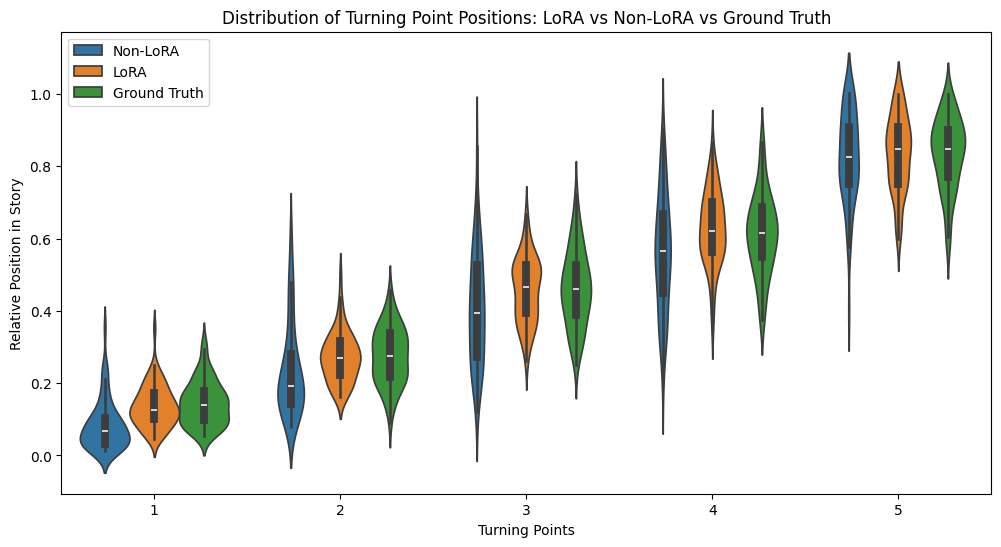

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create lists to store the normalized positions
non_lora_positions = {f'tp{i}': [] for i in range(1,6)}
lora_positions = {f'tp{i}': [] for i in range(1,6)}
ground_truth_positions = {f'tp{i}': [] for i in range(1,6)}

# Extract and normalize the positions
for idx, row in val_df.iterrows():
    if pd.notna(row['extracted_tp_non_lora']):
        tp_dict = eval(row['extracted_tp_non_lora']) if isinstance(row['extracted_tp_non_lora'], str) else row['extracted_tp_non_lora']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                non_lora_positions[key].append(tp_dict[key] / row['synopsis_len'])
                
    if pd.notna(row['extracted_tp_lora']):
        tp_dict = eval(row['extracted_tp_lora']) if isinstance(row['extracted_tp_lora'], str) else row['extracted_tp_lora']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                lora_positions[key].append(tp_dict[key] / row['synopsis_len'])
                
    if pd.notna(row['turning_points']):
        tp_dict = eval(row['turning_points']) if isinstance(row['turning_points'], str) else row['turning_points']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                ground_truth_positions[key].append(tp_dict[key] / row['synopsis_len'])

# Prepare data for violin plot
data_to_plot = []
labels = []
positions = []

for tp in range(1,6):
    key = f'tp{tp}'
    data_to_plot.extend(non_lora_positions[key])
    data_to_plot.extend(lora_positions[key])
    data_to_plot.extend(ground_truth_positions[key])
    labels.extend(['Non-LoRA']*len(non_lora_positions[key]))
    labels.extend(['LoRA']*len(lora_positions[key]))
    labels.extend(['Ground Truth']*len(ground_truth_positions[key]))
    positions.extend([tp]*len(non_lora_positions[key]))
    positions.extend([tp]*len(lora_positions[key]))
    positions.extend([tp]*len(ground_truth_positions[key]))

# Create the plot
plt.figure(figsize=(12, 6))
sns.violinplot(x=positions, y=data_to_plot, hue=labels)
plt.xlabel('Turning Points')
plt.ylabel('Relative Position in Story')
plt.title('Distribution of Turning Point Positions: LoRA vs Non-LoRA vs Ground Truth')
plt.show()
